Run App: "uvicorn main:app --reload"

# Imports

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from tqdm import tqdm
from typing import Dict
from scipy.signal import resample
import neurokit2 as nk
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline

# Import Data

Used Dataset:
- [WESAD: Multimodal Dataset for Wearable Stress and Affect Detection](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/): Exclusively importing the available pickle files from each subject (S2.pkl, S2.pkl, ...) and combining them
- Self-Generated Dataset (ECGPrivate):
    - Device: Bioplux Chest (and Finger) Band
    - Dataframes are modeled following the already implemented pydantic models

In [54]:
# Configs
# wesad respian sampling rate in hz
fs_wesad = 700

In [17]:
def dict_to_dataframe_WESAD(dict):
    df = pd.DataFrame()

    df["ECG"] = dict["signal"]["chest"]["ECG"].flatten()
    df["label"] = dict["label"].flatten()
    df["subject"] = dict["subject"]

    df.reset_index(names="timestamp_idx", inplace=True)

    return df

In [18]:
def combine_pickles_to_df(pattern, wesad_ecg=False):
    """
    Load multiple pickle files that contain similar pandas DataFrames and combine them into a single DataFrame.

    Args:
        pattern (str): A glob pattern that matches the pickle files to load.
        wesad (bool): Whether to convert dictionary objects to DataFrames (used for WESAD dataset).

    Returns:
        A pandas DataFrame that combines the loaded DataFrames.
    """
    dfs = []
    for file_path in tqdm(glob.glob(pattern)):
        with open(file_path, 'rb') as f:
            try:
                df = pd.read_pickle(f)
            except AttributeError:
                raise ValueError(f"Expected a pandas DataFrame, but got {type(df)}")
            if isinstance(df, Dict) and wesad_ecg:
                df = dict_to_dataframe_WESAD(df)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

### WESAD Data

In [19]:
%%time
# load WESAD
df = combine_pickles_to_df('../data/S15.pkl', wesad_ecg=True)

100%|██████████| 1/1 [00:13<00:00, 13.45s/it]

CPU times: total: 11.8 s
Wall time: 13.6 s


In [20]:
df

,timestamp_idx,ECG,label,subject
0,0,-0.025543,0,S15
1,1,-0.012955,0,S15
2,2,0.002518,0,S15
3,3,0.008011,0,S15
4,4,0.007141,0,S15
...,...,...,...,...
3676395,3676395,-0.165710,0,S15
3676396,3676396,-0.163330,0,S15
3676397,3676397,-0.138290,0,S15
3676398,3676398,-0.112106,0,S15


### Self-generated dataset

# Preprocessing

Remove noise via **bandpass filter**

In [55]:
def remove_noise(data, sampling_rate=360, lowcut=0.5, highcut=45):
    # Remove noise from ECG data using bandpass filter
    from scipy.signal import butter, filtfilt
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(4, [low, high], btype='band')
    raw_data = data.values
    filtered_data = filtfilt(b, a, raw_data)
    return filtered_data

In [57]:
filtered_ecg = df
filtered_ecg["ECG"] = remove_noise(filtered_ecg["ECG"], sampling_rate=fs_wesad)

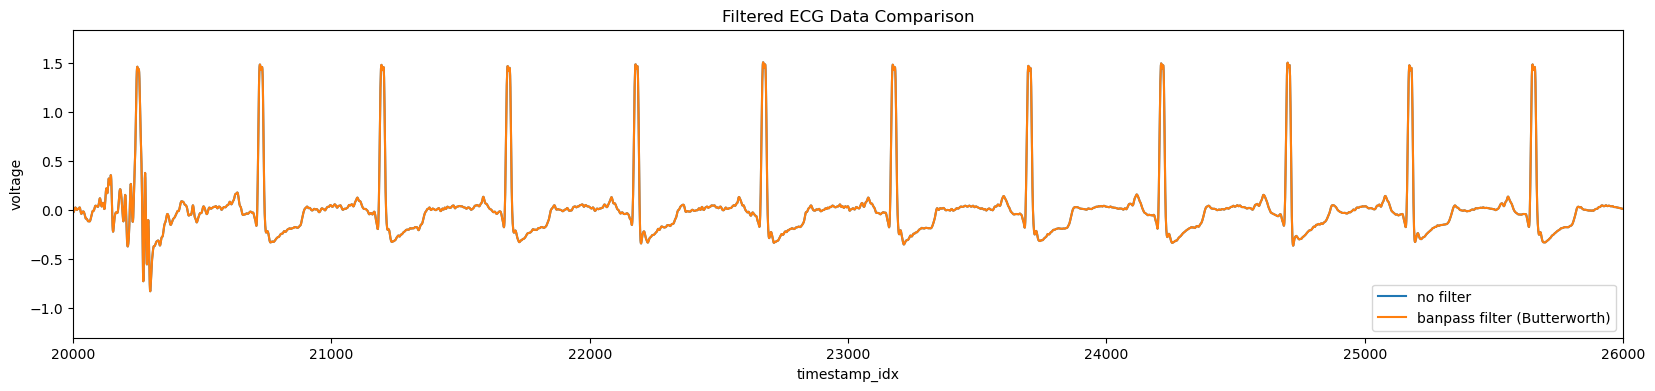

In [50]:
# Plot filtered ECG data
plt.figure(figsize=(20, 4))
plt.plot("timestamp_idx", "ECG", data=df, label="no filter")
plt.plot("timestamp_idx", "ECG", data=filtered_ecg, label="banpass filter (Butterworth)")
plt.title("Filtered ECG Data Comparison")
plt.xlabel("timestamp_idx")
plt.ylabel("voltage")
plt.xlim(20000, 26000)
plt.legend()
plt.show()

Process and clean via **pantompkins**

In [ ]:
# Process the ecg signal
#cleaned = nk.ecg_clean(df['ECG'], sampling_rate=fs, method="pantompkins1985")
#signals, info = nk.ecg_peaks(cleaned, sampling_rate=fs, method="pantompkins1985", correct_artifacts=True)

# Plot the data if of interest
#nk.events_plot(info["ECG_R_Peaks"], cleaned)